In [1]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 12.5 MB/s 
  Created wheel for pyod: filename=pyod-1.0.3-py3-none-any.whl size=154726 sha256=46b57b325e278b53720e0112c462fd8a3fdf3b034847422284ddcc4da658994f
  Stored in directory: /root/.cache/pip/wheels/60/1e/04/b42e786399bd7503af674d1ec95d93665b1700309ec3525b65
Successfully built pyod


In [2]:
!pip install combo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42884 sha256=c99400ec5fc97124691d1bbdb8f57bb942ff896635df8c5b0ca0fb69297c905d
  Stored in directory: /root/.cache/pip/wheels/b1/6e/c9/89dab355d4d5d58b11fe135b5839e8a3acc8b73273ffc68cde
Successfully built combo


In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("white")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score,\
    silhouette_score, f1_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score,\
    silhouette_score, f1_score
from pyod.models import knn, lof, hbos, iforest,ocsvm


from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.feature_bagging import FeatureBagging
def train_test(clf, X_train, X_test):
    # get the prediction label and outlier scores of the training data
    start = time.time()
    clf.fit(X_train)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    end_train = time.time()
    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    end = time.time()
    time_to_train = end_train-start
    time_to_test = end-end_train
    span = end - start
    print("Total time: ", span, "s.")

    return y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test

def co_train_test(clf, X_train, X_test):
    # get the prediction label and outlier scores of the training data
    start = time.time()
    clf.fit(X_train)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    end_train = time.time()
    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    end = time.time()
    time_to_train = end_train-start
    time_to_test = end-end_train
    span = end - start
#    print("Train time: ", time_to_train, "s.")
#    print("Test time: ", time_to_test, "s.")
    

    return y_train_pred, y_train_scores, y_test_pred, y_test_scores,clf.threshold_, time_to_train, time_to_test 

def my_metric(label,predict):
    CM = confusion_matrix(label,predict)
    CR = classification_report(label,predict)
    fpr, tpr, thresholds = roc_curve(label, predict)
    precision=precision_score(label, predict)
    recall=recall_score(label, predict)
    accuracy = accuracy_score(label, predict)
    f1=f1_score(label, predict, average='weighted')
    #AUC = auc(fpr, tpr)
    AUC=metrics.auc(fpr, tpr)

    results = {"Confusion Matrix":CM,"Classification Report":CR,"Area Under Curve":AUC}

    # show results
    for measure in results:
        print(measure,": \n",results[measure])
#     plt.plot(fpr, recall, 'k--', label='ROC (area = {0:.2f})'.format(AUC), lw=2)
    return fpr,tpr,f1,AUC, recall, accuracy
def baseline(X_train, X_test, y_train, y_test,model):
    start = time.time()

    if model == "knn":
        print ("Base Detector:"+model)
        clf = knn.KNN()
    elif model == "lof":
        print ("Base Detector:"+model)
        clf = lof.LOF()
    elif model == "hbos":
        print ("Base Detector:"+model)
        clf = hbos.HBOS()
    elif model == "iforest":
        print ("Base Detector:"+model)
        clf = iforest.IForest()
    elif model== "ocsvm":
        print ("Base Detector:"+model)
        clf = ocsvm.OCSVM()
    else:
        print("Please select a correct base model!")
    y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test= train_test(clf, X_train, X_test)
    print("\nTraining set:\n")
    _, _, _, _ ,_, _ = my_metric(y_train, y_train_pred)
    print("\nTest set:\n")
    fpr, tpr, f1, auc, recall, accuracy= my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train, time_to_test, recall, accuracy
def feature_bagging(X_train, X_test, y_train, y_test,basemodel,combination_function="mean"):

    start = time.time()
    #print ("FB base detector:"+basemodel)


    # train Feature Bagging detector
    clf_name = 'FeatureBagging'
    if basemodel=="knn":
        base_estimator=knn.KNN()
    elif basemodel=="lof":
        base_estimator = lof.LOF()
    elif basemodel == "hbos":
        base_estimator = hbos.HBOS()
    elif basemodel == "iforest":
        base_estimator = iforest.IForest()
    elif basemodel== "ocsvm":
        base_estimator = ocsvm.OCSVM()
    else:
        print("Please select a correct base model!")
    if combination_function=="mean":
        clf = FeatureBagging(base_estimator=base_estimator,check_estimator=False)
    else:
        clf = FeatureBagging(base_estimator=base_estimator,check_estimator=False,combination='max')
    # params
    clf.fit(X_train)

    print("Feature Bagging:")
    y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test = train_test(clf, X_train, X_test)
    print("training set:")
    _,_,_,_, _, _=my_metric(y_train, y_train_pred)
    print("test set:")
    fpr,tpr,f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)
    print("f1:",f1,"auc:",auc)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train, time_to_test,  recall, accuracy
def minmax(x):
    min=x.min()
    max=x.max()
    x = (x - min) / (max - min)
    return x,min,max
def parameter_ensemble(X_train, X_test, y_train, y_test,basemodel,combination_function="mean",span=10):
    #span :Determine the number of different parameters
    start = time.time()
    #print ("PR base detector:"+basemodel)
    threshold = []
    train_score=[]
    test_score=[]#np.zeros([X_test.shape[0],span])
    time_to_train=0
    time_to_test=0
    
    # for i in range(low, high + 1):
    for i in range(0, span):

        if basemodel == "knn":
            clf = knn.KNN(n_neighbors=i+5)
        elif basemodel == "lof":
            clf = lof.LOF(n_neighbors=i+20)
        elif basemodel == "hbos":
            clf = hbos.HBOS(n_bins=10+i)
        elif basemodel == "iforest":
            clf = iforest.IForest(n_estimators=i+100)
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM(degree=i+3)
        else:
            print("Please select a correct base model!")
        print("parameter ensemble:")

        y_train_pred, y_train_scores, y_test_pred, y_test_scores,threshold0, time_to_train0, time_to_test0= co_train_test(clf, X_train, X_test)
        #_, y_train_scores, y_test_pred, y_test_scores,threshold0, time_to_train0, time_to_test0= train_test(clf, X_train, X_test)
        time_to_train=time_to_train+time_to_train0
        time_to_test=time_to_test+time_to_test0
        _, _, f1, auc ,  recall, accuracy= my_metric(y_test, y_test_pred)

        y_test_scores=np.expand_dims(y_test_scores,-1)
        y_test_scores,min,max=minmax(y_test_scores)
        threshold0=(threshold0-min)/(max-min)
        test_score.append(y_test_scores)
        threshold.append(threshold0)
    print("PE Total time: ", time_to_train+time_to_test, "s.") 
    if combination_function=="mean":
        test_score = np.array(test_score).mean(0)
        threshold = np.array(threshold).mean()
    elif combination_function=="max":
        test_score = np.array(test_score).max(0)
        threshold = np.array(threshold).max()
    elif combination_function=="median":
        test_score =np.median(np.array(test_score),0)
        threshold = np.median(np.array(threshold),0)
    else:
        print("Please select a correct combination function!")
    # threshold = threshold/span
    
    
    print("training set:")
    fpr,tpr,f1, auc, recall, accuracy =my_metric(y_train, y_train_pred)
    print("test set:")
    fpr,tpr,f1, auc , recall, accuracy= my_metric(y_test, y_test_pred)
    #print("f1:",f1,"auc:",auc)
    
    y_test_pred = np.array(test_score > threshold).astype(np.int).flatten()
    fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train0, time_to_test0, recall, accuracy

def gram_schmidt(data):
    r, c = data.shape
    data = data.astype("float64")
    data[:, 0] = data[:, 0] / np.linalg.norm(data[:, 0])
    for j in range(1, c):
        y = data[:, j]
        sum = np.zeros((r,))
        for i in range(j):
            sum += np.dot(y, data[:, i]) * data[:, i]
        y -= sum
        y = y / np.linalg.norm(y)
        data[:, j] = y
    return data

def rotated_bagging(X_train, X_test):
    n, d = X_train.shape
    r = int(np.ceil(np.sqrt(d) * 0.5) + 0)
    E = np.random.uniform(size=(d, r))
    E = gram_schmidt(E)
    return np.matmul(X_train, E),np.matmul(X_test, E)

def subsample(data,mul=1):
    n = data.shape[0]
    a = 1 if n <= 50 else 50 / n
    b = 1 if n < 1000 else 1000 / n
    f = np.random.uniform(a, b)
    data = shuffle(data)
    m = np.floor(f * n*mul).astype("int32")
    return data.iloc[0:m]


def roteted_bagging(X_train0, X_test0, y_train, y_test,basemodel,combination_function="mean",loop=10):
    #loop: The number of subsets(Sample some features)

    start = time.time()

    test_score =[]
    threshold=[]
    time_to_train=0
    time_to_test=0
    for i in range(loop):

        X_train, X_test = rotated_bagging(X_train0, X_test0)


        if basemodel == "knn":
            clf = knn.KNN()
        elif basemodel == "lof":
            clf = lof.LOF()
        elif basemodel == "hbos":
            clf = hbos.HBOS()
        elif basemodel == "iforest":
            clf = iforest.IForest()
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM()
        else:
            print("Please select a correct base model!")

        y_train_pred, y_train_scores, y_test_pred, y_test_scores, threshold0, time_to_train0, time_to_test0= co_train_test(clf, X_train, X_test)
        time_to_train=time_to_train+time_to_train0
        time_to_test=time_to_test+time_to_test0
        
        y_test_scores=np.expand_dims(y_test_scores,-1)
        y_test_scores,min,max=minmax(y_test_scores)
        threshold0=(threshold0-min)/(max-min)
        test_score.append(y_test_scores)
        threshold.append(threshold0)
        _, _, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)
    print("RB Total time: ", time_to_train+time_to_test, "s.")
    if combination_function=="mean":
        test_score = np.array(test_score).mean(0)
        threshold = np.array(threshold).mean()
    elif combination_function=="max":
        test_score = np.array(test_score).max(0)
        threshold = np.array(threshold).max()
    elif combination_function=="median":
        test_score =np.median(np.array(test_score),0)
        threshold = np.median(np.array(threshold),0)
    else:
        print("Please select a correct combination function!")
    y_test_pred = np.array(test_score > threshold).astype(np.int).flatten()
    
    print("training set:")
    fpr,tpr,f1, auc, recall, accuracy=my_metric(y_train, y_train_pred)
    print("test set:")
    #print("f1:",f1,"auc:",auc)
    fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    

    return fpr, tpr, f1, auc, time_to_train0, time_to_test0, recall, accuracy
def variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel,combination_function="mean",loop=30, threshold = 1.9,mul=1):
    #loop: The number of subsets(Sample some data points)
    #threshold: A threshold that determines whether the data is abnormal
    #mul: Controls the size of a subset

    start = time.time()
    n_train=X_train.shape[0]
    N = df.shape[0]

    df = pd.DataFrame(np.concatenate([X_train, X_test],0))
    target = pd.DataFrame(np.concatenate([y_train, y_test],0))
    X_index = df.index

    y_VR = np.zeros((N, 2))
    y_VR = pd.DataFrame(y_VR, index=X_index, columns=['score', 'times'])
    for i in range(loop):
        X_train = subsample(df,mul)
        save = X_train.index

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)

        n1 = X_train.shape[0]
        if basemodel == "knn":
            clf = knn.KNN()
        elif basemodel == "lof":
            clf = lof.LOF()
        elif basemodel == "hbos":
            clf = hbos.HBOS()
        elif basemodel == "iforest":
            clf = iforest.IForest()
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM()
        else:
            print("Please select a correct base model!")

        clf.fit(X_train)
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores

        y_train_scores = y_train_scores[:, np.newaxis]
        scaler = StandardScaler()
        scaler.fit(y_train_scores)
        y_train_scores = scaler.transform(y_train_scores).flatten()

        if combination_function=="mean":
            y_VR.loc[save, "score"] += y_train_scores
        elif combination_function=="max":
            y_VR.loc[save, "score"] = np.max([y_train_scores,y_VR.loc[save, "score"]],0)
        else:
            print("Please select a correct combination function!")
        y_VR.loc[save, "times"] = y_VR.loc[save, "times"] + 1

    # if 0 in set(y_VR["times"]):
    #     # some points are not scored, we simply use a base method to the left data
    #     # we should avoid this situation
    #     has_test = True
    #     train_yvr = y_VR[y_VR["times"] != 0]
    #     test_index = y_VR[y_VR["times"] == 0].index
    #     if combination_function=="mean":
    #         train_score = train_yvr["score"] / train_yvr["times"]
    #     elif combination_function=="max":
    #         train_score = y_VR["score"]
    #     else:
    #         print("Please select a correct combination function!")
    #     y_train = target.loc[train_yvr.index]
    #     X_test = df.loc[test_index]
    #     if X_test.shape[0] > 10:
    #         scaler = StandardScaler()
    #         scaler.fit(X_test)
    #         X_test = scaler.transform(X_test)
    #         y_test = target.loc[test_index]
    #
   #         clf = lof.LOF()
    #         clf.fit(X_test)
    #         test_pred = clf.labels_
    #     else:
    #         test_pred = np.zeros((X_test.shape[0], 1))
    # #     test_score = clf.decision_scores_
    #
    # else:
    #     has_test = False
    #     if combination_function=="mean":
    #         train_score = y_VR["score"] / y_VR["times"]
    #     elif combination_function=="max":
    #         train_score = y_VR["score"]
    #     else:
    #         print("Please select a correct combination function!")
    #     y_train = target
    has_test = False
    if combination_function=="mean":
        train_score = y_VR["score"] / y_VR["times"]
    elif combination_function=="max":
        train_score = y_VR["score"]
    else:
        print("Please select a correct combination function!")
    y_train = target

    # %%
    if not has_test:
        y_train_pred = np.array(train_score > threshold).astype(np.int).flatten()
        
   
    
        _, _, _, _,_, _= my_metric(target[:n_train], y_train_pred[:n_train])
        #fpr, tpr, f1, auc = my_metric(target[n_train:], y_pred[n_train:])
        fpr, tpr, f1, auc , recall, accuracy= my_metric(target[n_train:], y_train_pred[n_train:])

    else:
        y_train_pred = np.array(train_score > threshold).astype(np.int).flatten()
        _, _, _, _,_, _= my_metric(y_train, y_train_pred)
        fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, test_pred)

    end = time.time()
    times = end - start
#    print("Train time: ", 0.8*times, "s.")
#    print("Test time: ", 0.2*times, "s.")
    print("VR Total time: ", times, "s.")

    return fpr, tpr, f1, auc,0.5*times, 0.5*times,recall, accuracy



In [4]:
from sklearn.cluster import KMeans
def cal_dist(x,y):
    return np.sqrt(sum(np.power(x-y,2)))
# cal knn dist in non-pruning dataset
def dis_matrix(data,n):
    mat=np.zeros((n,n))
    for i in range(n):
        mat[i,i]=0
        for j in range(i+1,n):
            mat[i,j]=cal_dist(data[i],data[j])
            mat[j,i]=mat[i,j]
    return mat

def ldof(data,k_neighbors,rank_n):
# rank_n: rank of outlier
# k: nearest neighbors
    n=data.shape[0]
    if rank_n>n:
        print("prune too many points")
        rank_n=n
    mat=dis_matrix(data,n)
    kv={}
    for i in range(n):
        sort_arr=np.sort(mat[i])
        sort_arr=sort_arr[1:k_neighbors+1]
        index=np.argsort(mat[i])
        index=index[1:k_neighbors+1]
        dp=np.sum(sort_arr)/k_neighbors
        temp=0
        for j in index:
            for k in index:
                temp+=mat[j,k]
        Dp=temp/(k_neighbors*(k_neighbors-1))
        kv[i]=dp/Dp
    a=sorted(kv.items(), key=lambda x: x[1])
    ls=list(dict(a).keys())
    return ls[len(ls)-rank_n:]
def pruning(X_train, X_test, y_train, y_test,k,k_neighbors,rank_n):
    n_train=X_train.shape[0]    
    postdata = np.concatenate([X_train, X_test],0)
    target = np.concatenate([y_train, y_test],0)

    start=time.time()
    #print ("Pruning:")
    N=postdata.shape[0]
    index=np.arange(N)
    km = KMeans(n_clusters=k).fit(postdata)
    center=km.cluster_centers_
    target_pred=km.predict(postdata)
    avgval=N/k
    non_pruned_data=[]
    non_pruned_index=[]
    flag=1
    for i in set(target_pred):
        if (target_pred[target_pred==i]).shape[0]<avgval:
            temp=postdata[target_pred==i]
            temp1=index[target_pred==i]
            if flag==1:
                flag=0
                non_pruned_data=temp
                non_pruned_index=temp1
            else:
                non_pruned_data=np.concatenate((non_pruned_data,temp),axis=0)
                non_pruned_index=np.concatenate((non_pruned_index,temp1),axis=0)
    sub_index=ldof(non_pruned_data,k_neighbors,rank_n)
    non_pruned_index=pd.Series(non_pruned_index)
    outlier_index=[]
    for i,j in zip(range(len(non_pruned_index)),non_pruned_index):
        if i in sub_index:
            outlier_index.append(j)
    end=time.time()
    times=end-start
#    print("Train time: ", 0.8*times, "s.")
#    print("Test time: ", 0.2*times, "s.")
    print("PR Total time: ", times, "s.")
    # evaluate
    
    y_pred = np.zeros((N,))
    for i in range(N):
        if i in list(outlier_index):
            y_pred[i] = 1
    #added fort the train setting
    _, _, _, _, _, _ = my_metric(target[:n_train], y_pred[:n_train])
    fpr, tpr, f1, auc , recall, accuracy= my_metric(target[n_train:], y_pred[n_train:])

    return fpr, tpr, f1, auc,0.5*times, 0.5*times, recall, accuracy



In [5]:
# %%load data
raisin = pd.read_csv("../content/drive/MyDrive/data/Raisin_Dataset.csv")

cls1 = raisin[0:450]
cls2 = raisin[451:900]

# %%
n_sample = 25
cls2 = shuffle(cls2)
cls2 = cls2[0:n_sample]
imbalanced_raisin = pd.concat([cls1, cls2], axis=0)

# preprocess part
kv = {"Kecimen": 0, "Besni": 1}
target = imbalanced_raisin["Class"].map(lambda x: kv[x])
df = imbalanced_raisin[imbalanced_raisin.columns[0:-1]]
data = df.values
# data=my_normalization(data)

# split data, target
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# StandardScaler
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)


In [6]:
#pruning
fpr_pr, tpr_pr, f1_pr, auc_pr,time_train_pr, time_test_pr, recall_pr, accuracy_pr=pruning(X_train, X_test, y_train, y_test,2,k_neighbors=10,rank_n=25)


PR Total time:  0.3004317283630371 s.
Confusion Matrix : 
 [[219   4]
 [  8   6]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       223
           1       0.60      0.43      0.50        14

    accuracy                           0.95       237
   macro avg       0.78      0.71      0.74       237
weighted avg       0.94      0.95      0.95       237

Area Under Curve : 
 0.7053171044202434
Confusion Matrix : 
 [[217  10]
 [  6   5]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       227
           1       0.33      0.45      0.38        11

    accuracy                           0.93       238
   macro avg       0.65      0.71      0.67       238
weighted avg       0.94      0.93      0.94       238

Area Under Curve : 
 0.7052462955546656


In [7]:
#knn
fpr_knn, tpr_knn, f1_knn, auc_knn,time_train_knn,time_test_knn, recall_knn, accuracy_knn=baseline(X_train, X_test, y_train, y_test,model="knn")


Base Detector:knn
Total time:  0.033127784729003906 s.

Training set:

Confusion Matrix : 
 [[210  13]
 [  3  11]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       223
           1       0.46      0.79      0.58        14

    accuracy                           0.93       237
   macro avg       0.72      0.86      0.77       237
weighted avg       0.95      0.93      0.94       237

Area Under Curve : 
 0.8637091607943626

Test set:

Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.33      0.73      0.46        11

    accuracy                           0.92       238
   macro avg       0.66      0.83      0.71       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.828394072887465


In [8]:
#feature bagging
fpr_fb_knn, tpr_fb_knn, f1_fb_knn, auc_fb_knn,time_train_fb_knn, time_test_fb_knn, recall_fb_knn, accuracy_fb_knn=feature_bagging(X_train, X_test, y_train, y_test,basemodel="knn")


Feature Bagging:
Total time:  0.31078004837036133 s.
training set:
Confusion Matrix : 
 [[210  13]
 [  3  11]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       223
           1       0.46      0.79      0.58        14

    accuracy                           0.93       237
   macro avg       0.72      0.86      0.77       237
weighted avg       0.95      0.93      0.94       237

Area Under Curve : 
 0.8637091607943626
test set:
Confusion Matrix : 
 [[210  17]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.95       227
           1       0.32      0.73      0.44        11

    accuracy                           0.92       238
   macro avg       0.65      0.83      0.70       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.8261914297156588
f1: 0.9309693574399456 auc: 0.8261914297156588


In [9]:
fpr_fb1_knn, tpr_fb1_knn, f1_fb1_knn, auc_fb1_knn,time_train_fb1_max_knn, time_test_fb1_max_knn, recall_fb1_knn, accuracy_fb1_knn=feature_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


Feature Bagging:
Total time:  0.32503485679626465 s.
training set:
Confusion Matrix : 
 [[210  13]
 [  3  11]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       223
           1       0.46      0.79      0.58        14

    accuracy                           0.93       237
   macro avg       0.72      0.86      0.77       237
weighted avg       0.95      0.93      0.94       237

Area Under Curve : 
 0.8637091607943626
test set:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.33      0.73      0.46        11

    accuracy                           0.92       238
   macro avg       0.66      0.83      0.71       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.828394072887465
f1: 0.933817336458393 auc: 0.828394072887465


In [10]:
#parameter ensemble
fpr_pe_knn, tpr_pe_knn, f1_pe_knn, auc_pe_knn,time_train_pe_knn, time_test_pe_knn, recall_pe_knn, accuracy_pe_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn")


parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.33      0.73      0.46        11

    accuracy                           0.92       238
   macro avg       0.66      0.83      0.71       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.828394072887465
parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.33      0.73      0.46        11

    accuracy                           0.92       238
   macro avg       0.66      0.83      0.71       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.828394072887465
parameter ensemble:
Confusion Matrix : 
 [[210  17]
 [  3   8]]
Classification Report : 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [11]:

fpr_pe1_knn, tpr_pe1_knn, f1_pe1_knn, auc_pe1_knn,time_train_pe1_max_knn, time_test_pe1_max_knn, recall_pe1_knn, accuracy_pe1_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.33      0.73      0.46        11

    accuracy                           0.92       238
   macro avg       0.66      0.83      0.71       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.828394072887465
parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.33      0.73      0.46        11

    accuracy                           0.92       238
   macro avg       0.66      0.83      0.71       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.828394072887465
parameter ensemble:
Confusion Matrix : 
 [[210  17]
 [  3   8]]
Classification Report : 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [12]:
fpr_pe2_knn, tpr_pe2_knn, f1_pe2_knn, auc_pe2_knn,time_train_pe2_median_knn, time_test_pe2_median_knn, recall_pe2_knn, accuracy_pe2_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.33      0.73      0.46        11

    accuracy                           0.92       238
   macro avg       0.66      0.83      0.71       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.828394072887465
parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.33      0.73      0.46        11

    accuracy                           0.92       238
   macro avg       0.66      0.83      0.71       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.828394072887465
parameter ensemble:
Confusion Matrix : 
 [[210  17]
 [  3   8]]
Classification Report : 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [13]:
#rotated bagging
fpr_rb_knn, tpr_rb_knn, f1_rb_knn, auc_rb_knn,time_train_rb_knn, time_test_rb_knn, recall_rb_knn, accuracy_rb_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn")


Confusion Matrix : 
 [[220   7]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       227
           1       0.53      0.73      0.62        11

    accuracy                           0.96       238
   macro avg       0.76      0.85      0.80       238
weighted avg       0.97      0.96      0.96       238

Area Under Curve : 
 0.8482178614337205
Confusion Matrix : 
 [[222   5]
 [  5   6]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       227
           1       0.55      0.55      0.55        11

    accuracy                           0.96       238
   macro avg       0.76      0.76      0.76       238
weighted avg       0.96      0.96      0.96       238

Area Under Curve : 
 0.7617140568682419
Confusion Matrix : 
 [[211  16]
 [  5   6]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [14]:
fpr_rb1_knn, tpr_rb1_knn, f1_rb1_knn, auc_rb1_knn,time_train_rb1_max_knn, time_test_rb1_max_knn, recall_rb1_knn, accuracy_rb1_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.33      0.73      0.46        11

    accuracy                           0.92       238
   macro avg       0.66      0.83      0.71       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.828394072887465
Confusion Matrix : 
 [[213  14]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.36      0.73      0.48        11

    accuracy                           0.93       238
   macro avg       0.67      0.83      0.72       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8327993592310773
Confusion Matrix : 
 [[221   6]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [15]:
fpr_rb2_knn, tpr_rb2_knn, f1_rb2_knn, auc_rb2_knn,time_train_rb2_median_knn, time_test_rb2_median_knn, recall_rb2_knn, accuracy_rb2_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="median")


Confusion Matrix : 
 [[222   5]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       227
           1       0.64      0.82      0.72        11

    accuracy                           0.97       238
   macro avg       0.82      0.90      0.85       238
weighted avg       0.97      0.97      0.97       238

Area Under Curve : 
 0.8980776932318784
Confusion Matrix : 
 [[215  12]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       227
           1       0.40      0.73      0.52        11

    accuracy                           0.94       238
   macro avg       0.69      0.84      0.74       238
weighted avg       0.96      0.94      0.95       238

Area Under Curve : 
 0.8372046455746898
Confusion Matrix : 
 [[213  14]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [16]:
#variable sampling with rotated bagging
fpr_vr_knn, tpr_vr_knn, f1_vr_knn, auc_vr_knn,time_train_vr_knn, time_test_vr_knn, recall_vr_knn, accuracy_vr_knn=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="knn",threshold=1.2)


Confusion Matrix : 
 [[219   4]
 [  4  10]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       223
           1       0.71      0.71      0.71        14

    accuracy                           0.97       237
   macro avg       0.85      0.85      0.85       237
weighted avg       0.97      0.97      0.97       237

Area Under Curve : 
 0.8481742472773863
Confusion Matrix : 
 [[219   8]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       227
           1       0.47      0.64      0.54        11

    accuracy                           0.95       238
   macro avg       0.72      0.80      0.76       238
weighted avg       0.96      0.95      0.95       238

Area Under Curve : 
 0.8005606728073688
VR Total time:  0.2853076457977295 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [17]:

fpr_vr1_knn, tpr_vr1_knn, f1_vr1_knn, auc_vr1_knn,time_train_vr1_max_knn, time_test_vr1_max_knn, recall_vr1_knn, accuracy_vr1_knn=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="knn",combination_function="max",threshold=1.2)


Confusion Matrix : 
 [[213  10]
 [  3  11]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       223
           1       0.52      0.79      0.63        14

    accuracy                           0.95       237
   macro avg       0.75      0.87      0.80       237
weighted avg       0.96      0.95      0.95       237

Area Under Curve : 
 0.8704356181934657
Confusion Matrix : 
 [[213  14]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.36      0.73      0.48        11

    accuracy                           0.93       238
   macro avg       0.67      0.83      0.72       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8327993592310773
VR Total time:  0.2521646022796631 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


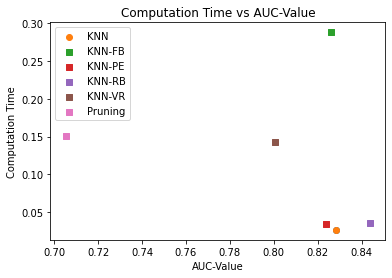

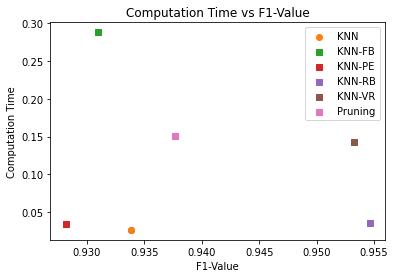

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


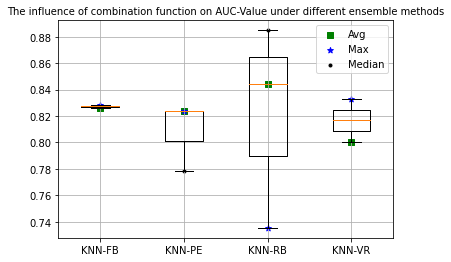

In [18]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_knn,auc_fb_knn, auc_pe_knn, auc_rb_knn , auc_vr_knn, auc_pr]
y = [time_test_knn,time_test_fb_knn, time_test_pe_knn, time_test_rb_knn, time_test_vr_knn, time_test_pr]
ax.scatter(x, y)  
txt = ['KNN', 'KNN-FB',  'KNN-PE', 'KNN-RB', 'KNN-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_knn,f1_fb_knn, f1_pe_knn, f1_rb_knn , f1_vr_knn,f1_pr]
y = [time_test_knn,time_test_fb_knn, time_test_pe_knn, time_test_rb_knn, time_test_vr_knn, time_test_pr]
ax.scatter(x, y)  
txt = ['KNN', 'KNN-FB',  'KNN-PE', 'KNN-RB', 'KNN-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='KNN-FB', "KNN-PE", 'KNN-RB','KNN-VR'

A = [auc_fb_knn,auc_fb1_knn]
B = [auc_pe_knn, auc_pe1_knn, auc_pe2_knn]
C = [auc_rb_knn, auc_rb1_knn, auc_rb2_knn]
D = [auc_vr_knn,auc_vr1_knn]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_knn,auc_pe_knn,auc_rb_knn,auc_vr_knn],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_knn,auc_pe1_knn,auc_rb1_knn,auc_vr1_knn],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_knn,auc_rb2_knn],label="Median",marker='.',c='k')

plt.legend()
plt.show()


In [19]:
#########################LOF
#lof
fpr_lof, tpr_lof, f1_lof, auc_lof,time_train_lof,time_test_lof, recall_lof, accuracy_lof=baseline(X_train, X_test, y_train, y_test,model="lof")


Base Detector:lof
Total time:  0.011630773544311523 s.

Training set:

Confusion Matrix : 
 [[210  13]
 [  3  11]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       223
           1       0.46      0.79      0.58        14

    accuracy                           0.93       237
   macro avg       0.72      0.86      0.77       237
weighted avg       0.95      0.93      0.94       237

Area Under Curve : 
 0.8637091607943626

Test set:

Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835


In [20]:
#feature bagging
fpr_fb_lof, tpr_fb_lof, f1_fb_lof, auc_fb_lof,time_train_fb_lof,time_test_fb_lof, recall_fb_lof, accuracy_fb_lof=feature_bagging(X_train, X_test, y_train, y_test,basemodel="lof")


Feature Bagging:
Total time:  0.07514119148254395 s.
training set:
Confusion Matrix : 
 [[211  12]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       223
           1       0.50      0.86      0.63        14

    accuracy                           0.94       237
   macro avg       0.75      0.90      0.80       237
weighted avg       0.96      0.94      0.95       237

Area Under Curve : 
 0.901665598975016
test set:
Confusion Matrix : 
 [[215  12]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       227
           1       0.40      0.73      0.52        11

    accuracy                           0.94       238
   macro avg       0.69      0.84      0.74       238
weighted avg       0.96      0.94      0.95       238

Area Under Curve : 
 0.8372046455746898
f1: 0.9454862771494971 auc: 0.8372046455746898


In [21]:
fpr_fb1_lof, tpr_fb1_lof, f1_fb1_lof, auc_fb1_lof,time_train_fb1_max_lof,time_test_fb1_max_lof, recall_fb1_lof, accuracy_fb1_lof=feature_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


Feature Bagging:
Total time:  0.0774686336517334 s.
training set:
Confusion Matrix : 
 [[211  12]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       223
           1       0.50      0.86      0.63        14

    accuracy                           0.94       237
   macro avg       0.75      0.90      0.80       237
weighted avg       0.96      0.94      0.95       237

Area Under Curve : 
 0.901665598975016
test set:
Confusion Matrix : 
 [[214  13]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       227
           1       0.35      0.64      0.45        11

    accuracy                           0.93       238
   macro avg       0.67      0.79      0.71       238
weighted avg       0.95      0.93      0.94       238

Area Under Curve : 
 0.789547456948338
f1: 0.93821778076943 auc: 0.789547456948338


In [22]:
#parameter ensemble
fpr_pe_lof, tpr_pe_lof, f1_pe_lof, auc_pe_lof,time_train_pe_lof,time_test_pe_lof, recall_pe_lof, accuracy_pe_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof")


parameter ensemble:
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835
parameter ensemble:
Confusion Matrix : 
 [[213  14]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.36      0.73      0.48        11

    accuracy                           0.93       238
   macro avg       0.67      0.83      0.72       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8327993592310773
parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [23]:
fpr_pe1_lof, tpr_pe1_lof, f1_pe1_lof, auc_pe1_lof,time_train_pe1_max_lof,time_test_pe1_max_lof, recall_pe1_lof, accuracy_pe1_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835
parameter ensemble:
Confusion Matrix : 
 [[213  14]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.36      0.73      0.48        11

    accuracy                           0.93       238
   macro avg       0.67      0.83      0.72       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8327993592310773
parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [24]:
fpr_pe2_lof, tpr_pe2_lof, f1_pe2_lof, auc_pe2_lof,time_train_pe2_median_lof,time_test_pe2_median_lof, recall_pe2_lof, accuracy_pe2_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835
parameter ensemble:
Confusion Matrix : 
 [[213  14]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.36      0.73      0.48        11

    accuracy                           0.93       238
   macro avg       0.67      0.83      0.72       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8327993592310773
parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [25]:
#rotated bagging
fpr_rb_lof, tpr_rb_lof, f1_rb_lof, auc_rb_lof,time_train_rb_lof,time_test_rb_lof, recall_rb_lof, accuracy_rb_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof")


Confusion Matrix : 
 [[211  16]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.36      0.82      0.50        11

    accuracy                           0.92       238
   macro avg       0.68      0.87      0.73       238
weighted avg       0.96      0.92      0.94       238

Area Under Curve : 
 0.8738486183420104
Confusion Matrix : 
 [[216  11]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       227
           1       0.42      0.73      0.53        11

    accuracy                           0.94       238
   macro avg       0.70      0.84      0.75       238
weighted avg       0.96      0.94      0.95       238

Area Under Curve : 
 0.8394072887464958
Confusion Matrix : 
 [[216  11]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [26]:
fpr_rb1_lof, tpr_rb1_lof, f1_rb1_lof, auc_rb1_lof,time_train_rb1_max_lof,time_test_rb1_max_lof, recall_rb1_lof, accuracy_rb1_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


Confusion Matrix : 
 [[219   8]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       227
           1       0.53      0.82      0.64        11

    accuracy                           0.96       238
   macro avg       0.76      0.89      0.81       238
weighted avg       0.97      0.96      0.96       238

Area Under Curve : 
 0.8914697637164598
Confusion Matrix : 
 [[219   8]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       227
           1       0.50      0.73      0.59        11

    accuracy                           0.95       238
   macro avg       0.74      0.85      0.78       238
weighted avg       0.96      0.95      0.96       238

Area Under Curve : 
 0.8460152182619142
Confusion Matrix : 
 [[214  13]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [27]:
fpr_rb2_lof, tpr_rb2_lof, f1_rb2_lof, auc_rb2_lof,time_train_rb2_median_lof,time_test_rb2_median_lof, recall_rb2_lof, accuracy_rb2_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="median")


Confusion Matrix : 
 [[212  15]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.38      0.82      0.51        11

    accuracy                           0.93       238
   macro avg       0.68      0.88      0.74       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8760512615138166
Confusion Matrix : 
 [[216  11]
 [  5   6]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       227
           1       0.35      0.55      0.43        11

    accuracy                           0.93       238
   macro avg       0.67      0.75      0.70       238
weighted avg       0.95      0.93      0.94       238

Area Under Curve : 
 0.7484981978374048
Confusion Matrix : 
 [[210  17]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [28]:
#variable sampling with rotated bagging
fpr_vr_lof, tpr_vr_lof, f1_vr_lof, auc_vr_lof,time_train_vr_lof,time_test_vr_lof, recall_vr_lof, accuracy_vr_lof=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="lof", loop=100)


Confusion Matrix : 
 [[220   3]
 [  7   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       223
           1       0.70      0.50      0.58        14

    accuracy                           0.96       237
   macro avg       0.83      0.74      0.78       237
weighted avg       0.95      0.96      0.95       237

Area Under Curve : 
 0.7432735426008967
Confusion Matrix : 
 [[225   2]
 [  5   6]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       227
           1       0.75      0.55      0.63        11

    accuracy                           0.97       238
   macro avg       0.86      0.77      0.81       238
weighted avg       0.97      0.97      0.97       238

Area Under Curve : 
 0.7683219863836603
VR Total time:  1.0157372951507568 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [29]:
fpr_vr1_lof, tpr_vr1_lof, f1_vr1_lof, auc_vr1_lof,time_train_vr1_max_lof,time_test_vr1_max_lof, recall_vr1_lof, accuracy_vr1_lof=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="lof",combination_function="max",loop=100,mul=200)


Confusion Matrix : 
 [[217   6]
 [  7   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       223
           1       0.54      0.50      0.52        14

    accuracy                           0.95       237
   macro avg       0.75      0.74      0.74       237
weighted avg       0.94      0.95      0.94       237

Area Under Curve : 
 0.7365470852017938
Confusion Matrix : 
 [[223   4]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       227
           1       0.64      0.64      0.64        11

    accuracy                           0.97       238
   macro avg       0.81      0.81      0.81       238
weighted avg       0.97      0.97      0.97       238

Area Under Curve : 
 0.8093712454945935
VR Total time:  1.2179105281829834 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


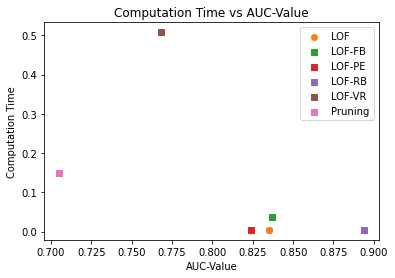

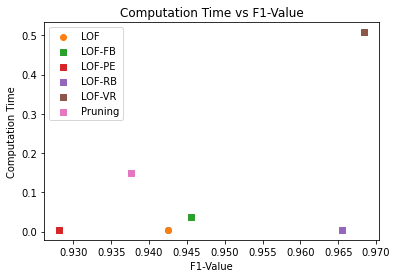

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


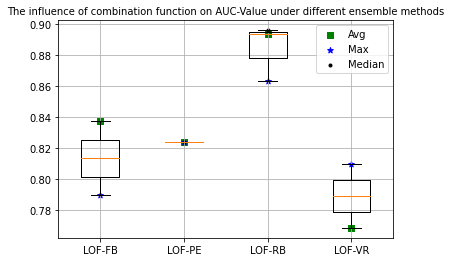

In [30]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_lof,auc_fb_lof, auc_pe_lof, auc_rb_lof , auc_vr_lof, auc_pr]
y = [time_test_lof,time_test_fb_lof, time_test_pe_lof, time_test_rb_lof, time_test_vr_lof, time_test_pr]
ax.scatter(x, y)  
txt = ['LOF', 'LOF-FB',  'LOF-PE', 'LOF-RB', 'LOF-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_lof,f1_fb_lof, f1_pe_lof, f1_rb_lof , f1_vr_lof, f1_pr]
y = [time_test_lof,time_test_fb_lof, time_test_pe_lof, time_test_rb_lof, time_test_vr_lof, time_test_pr]
ax.scatter(x, y)  
txt = ['LOF', 'LOF-FB',  'LOF-PE', 'LOF-RB', 'LOF-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='LOF-FB', "LOF-PE", 'LOF-RB','LOF-VR'
A = [auc_fb_lof,auc_fb1_lof]
B = [auc_pe_lof, auc_pe1_lof, auc_pe2_lof]
C = [auc_rb_lof, auc_rb1_lof, auc_rb2_lof]
D = [auc_vr_lof,auc_vr1_lof]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_lof,auc_pe_lof,auc_rb_lof,auc_vr_lof],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_lof,auc_pe1_lof,auc_rb1_lof,auc_vr1_lof],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_lof,auc_rb2_lof],label="Median",marker='.',c='k')

plt.legend()
plt.show()



In [31]:
##################################HBOS
#hbos
fpr_hbos, tpr_hbos, f1_hbos, auc_hbos,time_train_hbos,time_test_hbos, recall_hbos, accuracy_hbos=baseline(X_train, X_test, y_train, y_test,model="hbos")


Base Detector:hbos
Total time:  2.426074266433716 s.

Training set:

Confusion Matrix : 
 [[211  12]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       223
           1       0.50      0.86      0.63        14

    accuracy                           0.94       237
   macro avg       0.75      0.90      0.80       237
weighted avg       0.96      0.94      0.95       237

Area Under Curve : 
 0.901665598975016

Test set:

Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835


In [32]:
#feature bagging
fpr_fb_hbos, tpr_fb_hbos, f1_fb_hbos, auc_fb_hbos,time_train_fb_hbos,time_test_fb_hbos, recall_fb_hbos, accuracy_fb_hbos=feature_bagging(X_train, X_test, y_train, y_test,basemodel="hbos")


Feature Bagging:
Total time:  0.023096799850463867 s.
training set:
Confusion Matrix : 
 [[211  12]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       223
           1       0.50      0.86      0.63        14

    accuracy                           0.94       237
   macro avg       0.75      0.90      0.80       237
weighted avg       0.96      0.94      0.95       237

Area Under Curve : 
 0.901665598975016
test set:
Confusion Matrix : 
 [[213  14]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.36      0.73      0.48        11

    accuracy                           0.93       238
   macro avg       0.67      0.83      0.72       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8327993592310773
f1: 0.9395893797699667 auc: 0.8327993592310773


In [33]:
fpr_fb1_hbos, tpr_fb1_hbos, f1_fb1_hbos, auc_fb1_hbos,time_train_fb1_max_hbos,time_test_fb1_max_hbos, recall_fb1_hbos, accuracy_fb1_hbos=feature_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


Feature Bagging:
Total time:  0.04680466651916504 s.
training set:
Confusion Matrix : 
 [[211  12]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       223
           1       0.50      0.86      0.63        14

    accuracy                           0.94       237
   macro avg       0.75      0.90      0.80       237
weighted avg       0.96      0.94      0.95       237

Area Under Curve : 
 0.901665598975016
test set:
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835
f1: 0.9425202513437808 auc: 0.8350020024028835


In [34]:
#parameter ensemble
fpr_pe_hbos, tpr_pe_hbos, f1_pe_hbos, auc_pe_hbos,time_train_pe_hbos,time_test_pe_hbos, recall_pe_hbos, accuracy_pe_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos")


parameter ensemble:
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835
parameter ensemble:
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835
parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [35]:
fpr_pe1_hbos, tpr_pe1_hbos, f1_pe1_hbos, auc_pe1_hbos,time_train_pe1_max_hbos,time_test_pe1_max_hbos, recall_pe1_hbos, accuracy_pe1_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835
parameter ensemble:
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835
parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [36]:
fpr_pe2_hbos, tpr_pe2_hbos, f1_pe2_hbos, auc_pe2_hbos,time_train_pe2_median_hbos,time_test_pe2_median_hbos, recall_pe2_hbos, accuracy_pe2_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835
parameter ensemble:
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.38      0.73      0.50        11

    accuracy                           0.93       238
   macro avg       0.68      0.84      0.73       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8350020024028835
parameter ensemble:
Confusion Matrix : 
 [[211  16]
 [  3   8]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [37]:
#rotated bagging
fpr_rb_hbos, tpr_rb_hbos, f1_rb_hbos, auc_rb_hbos,time_train_rb_hbos,time_test_rb_hbos, recall_rb_hbos, accuracy_rb_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos")


Confusion Matrix : 
 [[221   6]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       227
           1       0.57      0.73      0.64        11

    accuracy                           0.96       238
   macro avg       0.78      0.85      0.81       238
weighted avg       0.97      0.96      0.96       238

Area Under Curve : 
 0.8504205046055267
Confusion Matrix : 
 [[217  10]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       227
           1       0.44      0.73      0.55        11

    accuracy                           0.95       238
   macro avg       0.72      0.84      0.76       238
weighted avg       0.96      0.95      0.95       238

Area Under Curve : 
 0.8416099319183019
Confusion Matrix : 
 [[206  21]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [38]:
fpr_rb1_hbos, tpr_rb1_hbos, f1_rb1_hbos, auc_rb1_hbos,time_train_rb1_max_hbos,time_test_rb1_max_hbos, recall_rb1_hbos, accuracy_rb1_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


Confusion Matrix : 
 [[220   7]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       227
           1       0.53      0.73      0.62        11

    accuracy                           0.96       238
   macro avg       0.76      0.85      0.80       238
weighted avg       0.97      0.96      0.96       238

Area Under Curve : 
 0.8482178614337205
Confusion Matrix : 
 [[221   6]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       227
           1       0.57      0.73      0.64        11

    accuracy                           0.96       238
   macro avg       0.78      0.85      0.81       238
weighted avg       0.97      0.96      0.96       238

Area Under Curve : 
 0.8504205046055267
Confusion Matrix : 
 [[216  11]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [39]:
fpr_rb2_hbos, tpr_rb2_hbos, f1_rb2_hbos, auc_rb2_hbos,time_train_rb2_median_hbos,time_test_rb2_median_hbos, recall_rb2_hbos, accuracy_rb2_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="median")


Confusion Matrix : 
 [[222   5]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       227
           1       0.62      0.73      0.67        11

    accuracy                           0.97       238
   macro avg       0.80      0.85      0.82       238
weighted avg       0.97      0.97      0.97       238

Area Under Curve : 
 0.8526231477773328
Confusion Matrix : 
 [[220   7]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       227
           1       0.53      0.73      0.62        11

    accuracy                           0.96       238
   macro avg       0.76      0.85      0.80       238
weighted avg       0.97      0.96      0.96       238

Area Under Curve : 
 0.8482178614337205
Confusion Matrix : 
 [[213  14]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [40]:
#variable sampling with rotated bagging
fpr_vr_hbos, tpr_vr_hbos, f1_vr_hbos, auc_vr_hbos,time_train_vr_hbos,time_test_vr_hbos, recall_vr_hbos, accuracy_vr_hbos=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="hbos")


Confusion Matrix : 
 [[221   2]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       223
           1       0.86      0.86      0.86        14

    accuracy                           0.98       237
   macro avg       0.92      0.92      0.92       237
weighted avg       0.98      0.98      0.98       237

Area Under Curve : 
 0.9240871236386932
Confusion Matrix : 
 [[224   3]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       227
           1       0.73      0.73      0.73        11

    accuracy                           0.97       238
   macro avg       0.86      0.86      0.86       238
weighted avg       0.97      0.97      0.97       238

Area Under Curve : 
 0.8570284341209451
VR Total time:  0.3324410915374756 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [41]:
fpr_vr1_hbos, tpr_vr1_hbos, f1_vr1_hbos, auc_vr1_hbos,time_train_vr1_max_hbos,time_test_vr1_max_hbos, recall_vr1_hbos, accuracy_vr1_hbos=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="hbos",combination_function="max")



Confusion Matrix : 
 [[215   8]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       223
           1       0.60      0.86      0.71        14

    accuracy                           0.96       237
   macro avg       0.80      0.91      0.84       237
weighted avg       0.97      0.96      0.96       237

Area Under Curve : 
 0.910634208840487
Confusion Matrix : 
 [[215  12]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       227
           1       0.40      0.73      0.52        11

    accuracy                           0.94       238
   macro avg       0.69      0.84      0.74       238
weighted avg       0.96      0.94      0.95       238

Area Under Curve : 
 0.8372046455746898
VR Total time:  0.2718491554260254 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


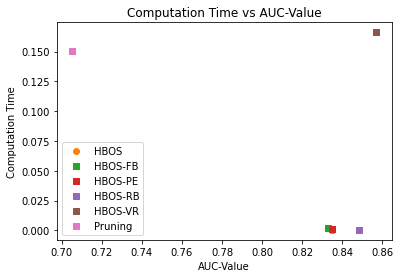

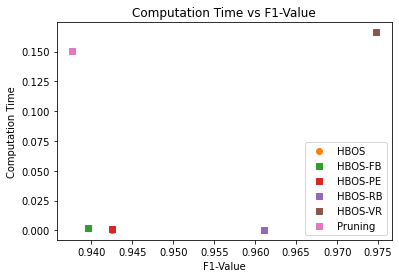

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


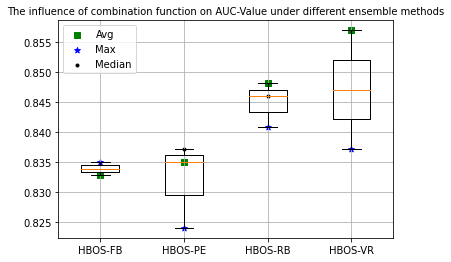

In [42]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_hbos,auc_fb_hbos, auc_pe_hbos, auc_rb_hbos , auc_vr_hbos, auc_pr]
y = [time_test_hbos,time_test_fb_hbos, time_test_pe_hbos, time_test_rb_hbos, time_test_vr_hbos, time_test_pr]
ax.scatter(x, y)  
txt = ['HBOS', 'HBOS-FB',  'HBOS-PE', 'HBOS-RB', 'HBOS-VR', 'Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_hbos,f1_fb_hbos, f1_pe_hbos, f1_rb_hbos , f1_vr_hbos,f1_pr]
y = [time_test_hbos,time_test_fb_hbos, time_test_pe_hbos, time_test_rb_hbos, time_test_vr_hbos, time_test_pr]
ax.scatter(x, y)  
txt = ['HBOS', 'HBOS-FB',  'HBOS-PE', 'HBOS-RB', 'HBOS-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()
#######

labels ='HBOS-FB', "HBOS-PE", 'HBOS-RB','HBOS-VR'
A = [auc_fb_hbos,auc_fb1_hbos]
B = [auc_pe_hbos, auc_pe1_hbos, auc_pe2_hbos]
C = [auc_rb_hbos, auc_rb1_hbos, auc_rb2_hbos]
D = [auc_vr_hbos,auc_vr1_hbos]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_hbos,auc_pe_hbos,auc_rb_hbos,auc_vr_hbos],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_hbos,auc_pe1_hbos,auc_rb1_hbos,auc_vr1_hbos],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_hbos,auc_rb2_hbos],label="Median",marker='.',c='k')
plt.legend()
plt.show()

In [43]:
# ##################################One-Class SVM
#ocsvm
fpr_ocsvm, tpr_ocsvm, f1_ocsvm, auc_ocsvm,time_train_ocsvm,time_test_ocsvm, recall_ocsvm, accuracy_ocsvm =baseline(X_train, X_test, y_train, y_test,model="ocsvm")


Base Detector:ocsvm
Total time:  0.014866113662719727 s.

Training set:

Confusion Matrix : 
 [[210  13]
 [  3  11]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       223
           1       0.46      0.79      0.58        14

    accuracy                           0.93       237
   macro avg       0.72      0.86      0.77       237
weighted avg       0.95      0.93      0.94       237

Area Under Curve : 
 0.8637091607943626

Test set:

Confusion Matrix : 
 [[206  21]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       227
           1       0.25      0.64      0.36        11

    accuracy                           0.89       238
   macro avg       0.62      0.77      0.65       238
weighted avg       0.95      0.89      0.92       238

Area Under Curve : 
 0.7719263115738886


In [44]:
#feature bagging
fpr_fb_ocsvm, tpr_fb_ocsvm, f1_fb_ocsvm, auc_fb_ocsvm,time_train_fb_ocsvm,time_test_fb_ocsvm, recall_fb_ocsvm, accuracy_fb_ocsvm =feature_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm")


Feature Bagging:
Total time:  0.11767005920410156 s.
training set:
Confusion Matrix : 
 [[211  12]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       223
           1       0.50      0.86      0.63        14

    accuracy                           0.94       237
   macro avg       0.75      0.90      0.80       237
weighted avg       0.96      0.94      0.95       237

Area Under Curve : 
 0.901665598975016
test set:
Confusion Matrix : 
 [[205  22]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       227
           1       0.29      0.82      0.43        11

    accuracy                           0.90       238
   macro avg       0.64      0.86      0.69       238
weighted avg       0.96      0.90      0.92       238

Area Under Curve : 
 0.8606327593111734
f1: 0.9208457576579019 auc: 0.8606327593111734


In [45]:
fpr_fb1_ocsvm, tpr_fb1_ocsvm, f1_fb1_ocsvm, auc_fb1_ocsvm,time_train_fb1_max_ocsvm,time_test_fb1_max_ocsvm, recall_fb1_ocsvm, accuracy_fb1_ocsvm=feature_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


Feature Bagging:
Total time:  0.10887813568115234 s.
training set:
Confusion Matrix : 
 [[211  12]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       223
           1       0.50      0.86      0.63        14

    accuracy                           0.94       237
   macro avg       0.75      0.90      0.80       237
weighted avg       0.96      0.94      0.95       237

Area Under Curve : 
 0.901665598975016
test set:
Confusion Matrix : 
 [[208  19]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       227
           1       0.32      0.82      0.46        11

    accuracy                           0.91       238
   macro avg       0.66      0.87      0.71       238
weighted avg       0.96      0.91      0.93       238

Area Under Curve : 
 0.867240688826592
f1: 0.9292792279735341 auc: 0.867240688826592


In [46]:
#parameter ensemble
fpr_pe_ocsvm, tpr_pe_ocsvm, f1_pe_ocsvm, auc_pe_ocsvm,time_train_pe_ocsvm,time_test_pe_ocsvm, recall_pe_ocsvm, accuracy_pe_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm")


parameter ensemble:
Confusion Matrix : 
 [[206  21]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       227
           1       0.25      0.64      0.36        11

    accuracy                           0.89       238
   macro avg       0.62      0.77      0.65       238
weighted avg       0.95      0.89      0.92       238

Area Under Curve : 
 0.7719263115738886
parameter ensemble:
Confusion Matrix : 
 [[206  21]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       227
           1       0.25      0.64      0.36        11

    accuracy                           0.89       238
   macro avg       0.62      0.77      0.65       238
weighted avg       0.95      0.89      0.92       238

Area Under Curve : 
 0.7719263115738886
parameter ensemble:
Confusion Matrix : 
 [[206  21]
 [  4   7]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [47]:
fpr_pe1_ocsvm, tpr_pe1_ocsvm, f1_pe1_ocsvm, auc_pe1_ocsvm,time_train_pe1_max_ocsvm,time_test_pe1_max_ocsvm, recall_pe1_ocsvm, accuracy_pe1_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[206  21]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       227
           1       0.25      0.64      0.36        11

    accuracy                           0.89       238
   macro avg       0.62      0.77      0.65       238
weighted avg       0.95      0.89      0.92       238

Area Under Curve : 
 0.7719263115738886
parameter ensemble:
Confusion Matrix : 
 [[206  21]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       227
           1       0.25      0.64      0.36        11

    accuracy                           0.89       238
   macro avg       0.62      0.77      0.65       238
weighted avg       0.95      0.89      0.92       238

Area Under Curve : 
 0.7719263115738886
parameter ensemble:
Confusion Matrix : 
 [[206  21]
 [  4   7]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [48]:
fpr_pe2_ocsvm, tpr_pe2_ocsvm, f1_pe2_ocsvm, auc_pe2_ocsvm,time_train_pe2_median_ocsvm,time_test_pe2_median_ocsvm, recall_pe2_ocsvm, accuracy_pe2_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[206  21]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       227
           1       0.25      0.64      0.36        11

    accuracy                           0.89       238
   macro avg       0.62      0.77      0.65       238
weighted avg       0.95      0.89      0.92       238

Area Under Curve : 
 0.7719263115738886
parameter ensemble:
Confusion Matrix : 
 [[206  21]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       227
           1       0.25      0.64      0.36        11

    accuracy                           0.89       238
   macro avg       0.62      0.77      0.65       238
weighted avg       0.95      0.89      0.92       238

Area Under Curve : 
 0.7719263115738886
parameter ensemble:
Confusion Matrix : 
 [[206  21]
 [  4   7]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [49]:
#rotated bagging
fpr_rb_ocsvm, tpr_rb_ocsvm, f1_rb_ocsvm, auc_rb_ocsvm,time_train_rb_ocsvm,time_test_rb_ocsvm, recall_rb_ocsvm, accuracy_rb_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm")


Confusion Matrix : 
 [[217  10]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       227
           1       0.47      0.82      0.60        11

    accuracy                           0.95       238
   macro avg       0.73      0.89      0.79       238
weighted avg       0.97      0.95      0.96       238

Area Under Curve : 
 0.8870644773728475
Confusion Matrix : 
 [[219   8]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       227
           1       0.50      0.73      0.59        11

    accuracy                           0.95       238
   macro avg       0.74      0.85      0.78       238
weighted avg       0.96      0.95      0.96       238

Area Under Curve : 
 0.8460152182619142
Confusion Matrix : 
 [[206  21]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [50]:
fpr_rb1_ocsvm, tpr_rb1_ocsvm, f1_rb1_ocsvm, auc_rb1_ocsvm,time_train_rb1_max_ocsvm,time_test_rb1_max_ocsvm, recall_rb1_ocsvm, accuracy_rb1_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


Confusion Matrix : 
 [[213  14]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       227
           1       0.36      0.73      0.48        11

    accuracy                           0.93       238
   macro avg       0.67      0.83      0.72       238
weighted avg       0.96      0.93      0.94       238

Area Under Curve : 
 0.8327993592310773
Confusion Matrix : 
 [[212  15]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.35      0.73      0.47        11

    accuracy                           0.92       238
   macro avg       0.67      0.83      0.71       238
weighted avg       0.96      0.92      0.94       238

Area Under Curve : 
 0.8305967160592712
Confusion Matrix : 
 [[217  10]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [51]:
fpr_rb2_ocsvm, tpr_rb2_ocsvm, f1_rb2_ocsvm, auc_rb2_ocsvm,time_train_rb2_median_ocsvm,time_test_rb2_median_ocsvm, recall_rb2_ocsvm, accuracy_rb2_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="median")


Confusion Matrix : 
 [[215  12]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       227
           1       0.43      0.82      0.56        11

    accuracy                           0.94       238
   macro avg       0.71      0.88      0.77       238
weighted avg       0.96      0.94      0.95       238

Area Under Curve : 
 0.8826591910292352
Confusion Matrix : 
 [[209  18]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       227
           1       0.31      0.73      0.43        11

    accuracy                           0.91       238
   macro avg       0.65      0.82      0.69       238
weighted avg       0.95      0.91      0.93       238

Area Under Curve : 
 0.8239887865438527
Confusion Matrix : 
 [[217  10]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [52]:
#variable sampling with rotated bagging
fpr_vr_ocsvm, tpr_vr_ocsvm, f1_vr_ocsvm, auc_vr_ocsvm,time_train_vr_ocsvm,time_test_vr_ocsvm, recall_vr_ocsvm, accuracy_vr_ocsvm=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="ocsvm",threshold=1.2)


Confusion Matrix : 
 [[209  14]
 [  3  11]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       223
           1       0.44      0.79      0.56        14

    accuracy                           0.93       237
   macro avg       0.71      0.86      0.76       237
weighted avg       0.95      0.93      0.94       237

Area Under Curve : 
 0.8614670083279948
Confusion Matrix : 
 [[205  22]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       227
           1       0.27      0.73      0.39        11

    accuracy                           0.89       238
   macro avg       0.63      0.82      0.67       238
weighted avg       0.95      0.89      0.92       238

Area Under Curve : 
 0.815178213856628
VR Total time:  0.4405834674835205 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [53]:
fpr_vr1_ocsvm, tpr_vr1_ocsvm, f1_vr1_ocsvm, auc_vr1_ocsvm,time_train_vr1_max_ocsvm,time_test_vr1_max_ocsvm, recall_vr1_ocsvm, accuracy_vr1_ocsvm=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="ocsvm",combination_function="max",threshold=1.2)


Confusion Matrix : 
 [[201  22]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       223
           1       0.35      0.86      0.50        14

    accuracy                           0.90       237
   macro avg       0.67      0.88      0.72       237
weighted avg       0.95      0.90      0.92       237

Area Under Curve : 
 0.879244074311339
Confusion Matrix : 
 [[202  25]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94       227
           1       0.26      0.82      0.40        11

    accuracy                           0.89       238
   macro avg       0.63      0.85      0.67       238
weighted avg       0.96      0.89      0.91       238

Area Under Curve : 
 0.854024829795755
VR Total time:  0.4601864814758301 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


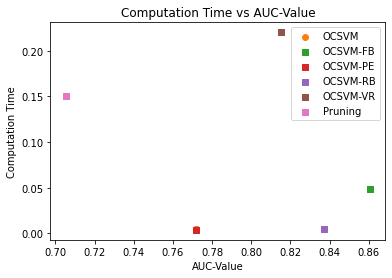

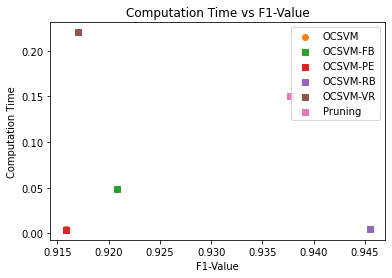

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


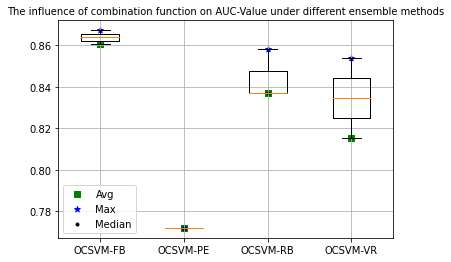

In [54]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_ocsvm,auc_fb_ocsvm, auc_pe_ocsvm, auc_rb_ocsvm , auc_vr_ocsvm, auc_pr]
y = [time_test_ocsvm,time_test_fb_ocsvm, time_test_pe_ocsvm, time_test_rb_ocsvm, time_test_vr_ocsvm, time_test_pr]
ax.scatter(x, y)  
txt = ['OCSVM', 'OCSVM-FB',  'OCSVM-PE', 'OCSVM-RB', 'OCSVM-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_ocsvm,f1_fb_ocsvm, f1_pe_ocsvm, f1_rb_ocsvm , f1_vr_ocsvm, f1_pr]
y = [time_test_ocsvm,time_test_fb_ocsvm, time_test_pe_ocsvm, time_test_rb_ocsvm, time_test_vr_ocsvm, time_test_pr]
ax.scatter(x, y)  
txt = ['OCSVM', 'OCSVM-FB',  'OCSVM-PE', 'OCSVM-RB', 'OCSVM-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='OCSVM-FB', "OCSVM-PE", 'OCSVM-RB','OCSVM-VR'

A = [auc_fb_ocsvm,auc_fb1_ocsvm]
B = [auc_pe_ocsvm, auc_pe1_ocsvm, auc_pe2_ocsvm]
C = [auc_rb_ocsvm, auc_rb1_ocsvm, auc_rb2_ocsvm]
D = [auc_vr_ocsvm,auc_vr1_ocsvm]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_ocsvm,auc_pe_ocsvm,auc_rb_ocsvm,auc_vr_ocsvm],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_ocsvm,auc_pe1_ocsvm,auc_rb1_ocsvm,auc_vr1_ocsvm],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_ocsvm,auc_rb2_ocsvm],label="Median",marker='.',c='k')
#
plt.legend()
plt.show()


In [55]:
##################################IForest
#iforest
fpr_ifo, tpr_ifo, f1_ifo, auc_ifo,time_train_ifo,time_test_ifo,recall_ifo, accuracy_ifo =baseline(X_train, X_test, y_train, y_test,model="iforest")


Base Detector:iforest
Total time:  0.2973499298095703 s.

Training set:

Confusion Matrix : 
 [[210  13]
 [  3  11]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       223
           1       0.46      0.79      0.58        14

    accuracy                           0.93       237
   macro avg       0.72      0.86      0.77       237
weighted avg       0.95      0.93      0.94       237

Area Under Curve : 
 0.8637091607943626

Test set:

Confusion Matrix : 
 [[212  15]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.93      0.96       227
           1       0.32      0.64      0.42        11

    accuracy                           0.92       238
   macro avg       0.65      0.79      0.69       238
weighted avg       0.95      0.92      0.93       238

Area Under Curve : 
 0.7851421706047257


In [56]:
#feature bagging
fpr_fb_ifo, tpr_fb_ifo, f1_fb_ifo, auc_fb_ifo,time_train_fb_ifo,time_test_fb_ifo,recall_fb_ifo, accuracy_fb_ifo=feature_bagging(X_train, X_test, y_train, y_test,basemodel="iforest")


Feature Bagging:
Total time:  2.757432460784912 s.
training set:
Confusion Matrix : 
 [[210  13]
 [  3  11]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       223
           1       0.46      0.79      0.58        14

    accuracy                           0.93       237
   macro avg       0.72      0.86      0.77       237
weighted avg       0.95      0.93      0.94       237

Area Under Curve : 
 0.8637091607943626
test set:
Confusion Matrix : 
 [[207  20]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95       227
           1       0.29      0.73      0.41        11

    accuracy                           0.90       238
   macro avg       0.64      0.82      0.68       238
weighted avg       0.95      0.90      0.92       238

Area Under Curve : 
 0.8195835002002403
f1: 0.922543916351966 auc: 0.8195835002002403


In [57]:
fpr_fb1_ifo, tpr_fb1_ifo, f1_fb1_ifo, auc_fb1_ifo,time_train_fb1_max_ifo,time_test_fb1_max_ifo,recall_fb1_ifo, accuracy_fb1_ifo=feature_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


Feature Bagging:
Total time:  2.746976852416992 s.
training set:
Confusion Matrix : 
 [[209  14]
 [  4  10]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       223
           1       0.42      0.71      0.53        14

    accuracy                           0.92       237
   macro avg       0.70      0.83      0.74       237
weighted avg       0.95      0.92      0.93       237

Area Under Curve : 
 0.8257527226137092
test set:
Confusion Matrix : 
 [[205  22]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       227
           1       0.24      0.64      0.35        11

    accuracy                           0.89       238
   macro avg       0.61      0.77      0.65       238
weighted avg       0.95      0.89      0.91       238

Area Under Curve : 
 0.7697236684020825
f1: 0.9130811040012334 auc: 0.7697236684020825


In [58]:
#parameter ensemble
fpr_pe_ifo, tpr_pe_ifo, f1_pe_ifo, auc_pe_ifo,time_train_pe_ifo,time_test_pe_ifo,recall_pe_ifo, accuracy_pe_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest")


parameter ensemble:
Confusion Matrix : 
 [[210  17]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       227
           1       0.35      0.82      0.49        11

    accuracy                           0.92       238
   macro avg       0.67      0.87      0.72       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.8716459751702044
parameter ensemble:
Confusion Matrix : 
 [[209  18]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       227
           1       0.28      0.64      0.39        11

    accuracy                           0.91       238
   macro avg       0.63      0.78      0.67       238
weighted avg       0.95      0.91      0.92       238

Area Under Curve : 
 0.7785342410893071
parameter ensemble:
Confusion Matrix : 
 [[207  20]
 [  3   8]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [59]:
fpr_pe1_ifo, tpr_pe1_ifo, f1_pe1_ifo, auc_pe1_ifo,time_train_pe1_max_ifo,time_test_pe1_max_ifo,recall_pe1_ifo, accuracy_pe1_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[210  17]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.95       227
           1       0.32      0.73      0.44        11

    accuracy                           0.92       238
   macro avg       0.65      0.83      0.70       238
weighted avg       0.96      0.92      0.93       238

Area Under Curve : 
 0.8261914297156588
parameter ensemble:
Confusion Matrix : 
 [[209  18]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       227
           1       0.31      0.73      0.43        11

    accuracy                           0.91       238
   macro avg       0.65      0.82      0.69       238
weighted avg       0.95      0.91      0.93       238

Area Under Curve : 
 0.8239887865438527
parameter ensemble:
Confusion Matrix : 
 [[209  18]
 [  2   9]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [60]:
fpr_pe2_ifo, tpr_pe2_ifo, f1_pe2_ifo, auc_pe2_ifo,time_train_pe2_median_ifo,time_test_pe2_median_ifo,recall_pe2_ifo, accuracy_pe2_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[207  20]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95       227
           1       0.29      0.73      0.41        11

    accuracy                           0.90       238
   macro avg       0.64      0.82      0.68       238
weighted avg       0.95      0.90      0.92       238

Area Under Curve : 
 0.8195835002002403
parameter ensemble:
Confusion Matrix : 
 [[207  20]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.91      0.95       227
           1       0.26      0.64      0.37        11

    accuracy                           0.90       238
   macro avg       0.62      0.77      0.66       238
weighted avg       0.95      0.90      0.92       238

Area Under Curve : 
 0.7741289547456948
parameter ensemble:
Confusion Matrix : 
 [[207  20]
 [  3   8]]
Classification Report 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [61]:
#rotated bagging
fpr_rb_ifo, tpr_rb_ifo, f1_rb_ifo, auc_rb_ifo,time_train_rb_ifo,time_test_rb_ifo,recall_rb_ifo, accuracy_rb_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest")


Confusion Matrix : 
 [[216  11]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       227
           1       0.42      0.73      0.53        11

    accuracy                           0.94       238
   macro avg       0.70      0.84      0.75       238
weighted avg       0.96      0.94      0.95       238

Area Under Curve : 
 0.8394072887464958
Confusion Matrix : 
 [[211  16]
 [  5   6]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       227
           1       0.27      0.55      0.36        11

    accuracy                           0.91       238
   macro avg       0.62      0.74      0.66       238
weighted avg       0.94      0.91      0.93       238

Area Under Curve : 
 0.7374849819783741
Confusion Matrix : 
 [[214  13]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [62]:
fpr_rb1_ifo, tpr_rb1_ifo, f1_rb1_ifo, auc_rb1_ifo,time_train_rb1_max_ifo,time_test_rb1_max_ifo,recall_rb1_ifo, accuracy_rb1_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


Confusion Matrix : 
 [[207  20]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95       227
           1       0.29      0.73      0.41        11

    accuracy                           0.90       238
   macro avg       0.64      0.82      0.68       238
weighted avg       0.95      0.90      0.92       238

Area Under Curve : 
 0.8195835002002403
Confusion Matrix : 
 [[205  22]
 [  5   6]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       227
           1       0.21      0.55      0.31        11

    accuracy                           0.89       238
   macro avg       0.60      0.72      0.62       238
weighted avg       0.94      0.89      0.91       238

Area Under Curve : 
 0.724269122947537
Confusion Matrix : 
 [[206  21]
 [  5   6]]
Classification Report : 
               precision    recall  f1-score   support

  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [63]:
fpr_rb2_ifo, tpr_rb2_ifo, f1_rb2_ifo, auc_rb2_ifo,time_train_rb2_median_ifo,time_test_rb2_median_ifo,recall_rb2_ifo, accuracy_rb2_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="median")


Confusion Matrix : 
 [[205  22]
 [  6   5]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94       227
           1       0.19      0.45      0.26        11

    accuracy                           0.88       238
   macro avg       0.58      0.68      0.60       238
weighted avg       0.94      0.88      0.90       238

Area Under Curve : 
 0.6788145774929916
Confusion Matrix : 
 [[218   9]
 [  3   8]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       227
           1       0.47      0.73      0.57        11

    accuracy                           0.95       238
   macro avg       0.73      0.84      0.77       238
weighted avg       0.96      0.95      0.95       238

Area Under Curve : 
 0.8438125750901081
Confusion Matrix : 
 [[213  14]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [64]:
#variable sampling with rotated bagging
fpr_vr_ifo, tpr_vr_ifo, f1_vr_ifo, auc_vr_ifo,time_train_vr_ifo,time_test_vr_ifo,recall_vr_ifo, accuracy_vr_ifo=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="iforest",threshold=1.2)


Confusion Matrix : 
 [[211  12]
 [  3  11]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       223
           1       0.48      0.79      0.59        14

    accuracy                           0.94       237
   macro avg       0.73      0.87      0.78       237
weighted avg       0.96      0.94      0.94       237

Area Under Curve : 
 0.8659513132607302
Confusion Matrix : 
 [[209  18]
 [  4   7]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       227
           1       0.28      0.64      0.39        11

    accuracy                           0.91       238
   macro avg       0.63      0.78      0.67       238
weighted avg       0.95      0.91      0.92       238

Area Under Curve : 
 0.7785342410893071
VR Total time:  6.178349256515503 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [65]:
fpr_vr1_ifo, tpr_vr1_ifo, f1_vr1_ifo, auc_vr1_ifo,time_train_vr1_max_ifo,time_test_vr1_max_ifo,recall_vr1_ifo, accuracy_vr1_ifo=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="iforest",combination_function="max",threshold=1.2)


Confusion Matrix : 
 [[196  27]
 [  2  12]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.88      0.93       223
           1       0.31      0.86      0.45        14

    accuracy                           0.88       237
   macro avg       0.65      0.87      0.69       237
weighted avg       0.95      0.88      0.90       237

Area Under Curve : 
 0.8680333119795003
Confusion Matrix : 
 [[198  29]
 [  2   9]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.87      0.93       227
           1       0.24      0.82      0.37        11

    accuracy                           0.87       238
   macro avg       0.61      0.85      0.65       238
weighted avg       0.96      0.87      0.90       238

Area Under Curve : 
 0.8452142571085303
VR Total time:  6.078137636184692 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


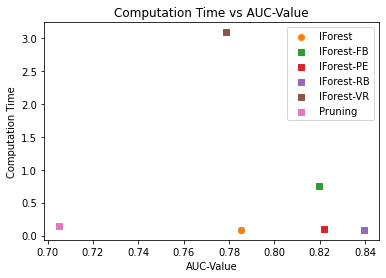

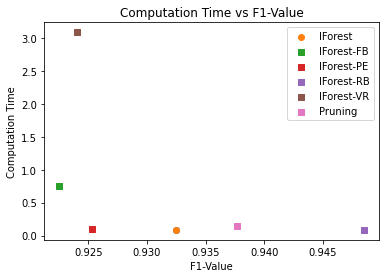

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


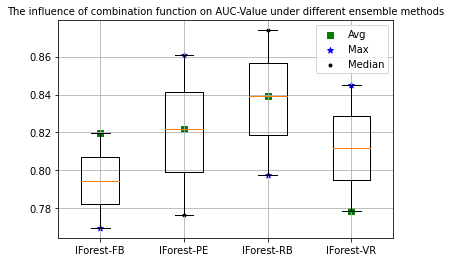

In [66]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_ifo,auc_fb_ifo, auc_pe_ifo, auc_rb_ifo , auc_vr_ifo,auc_pr]
y = [time_test_ifo,time_test_fb_ifo, time_test_pe_ifo, time_test_rb_ifo, time_test_vr_ifo, time_test_pr]
ax.scatter(x, y)  
txt = ['IForest', 'IForest-FB',  'IForest-PE', 'IForest-RB', 'IForest-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_ifo,f1_fb_ifo, f1_pe_ifo, f1_rb_ifo , f1_vr_ifo,f1_pr]
y = [time_test_ifo,time_test_fb_ifo, time_test_pe_ifo, time_test_rb_ifo, time_test_vr_ifo, time_test_pr]
ax.scatter(x, y)  
txt = ['IForest', 'IForest-FB',  'IForest-PE', 'IForest-RB', 'IForest-VR','Pruning']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='IForest-FB', "IForest-PE", 'IForest-RB','IForest-VR'

A = [auc_fb_ifo,auc_fb1_ifo]
B = [auc_pe_ifo, auc_pe1_ifo, auc_pe2_ifo]
C = [auc_rb_ifo, auc_rb1_ifo, auc_rb2_ifo]
D = [auc_vr_ifo,auc_vr1_ifo]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_ifo,auc_pe_ifo,auc_rb_ifo,auc_vr_ifo],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_ifo,auc_pe1_ifo,auc_rb1_ifo,auc_vr1_ifo],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_ifo,auc_rb2_ifo],label="Median",marker='.',c='k')

plt.legend()
plt.show()


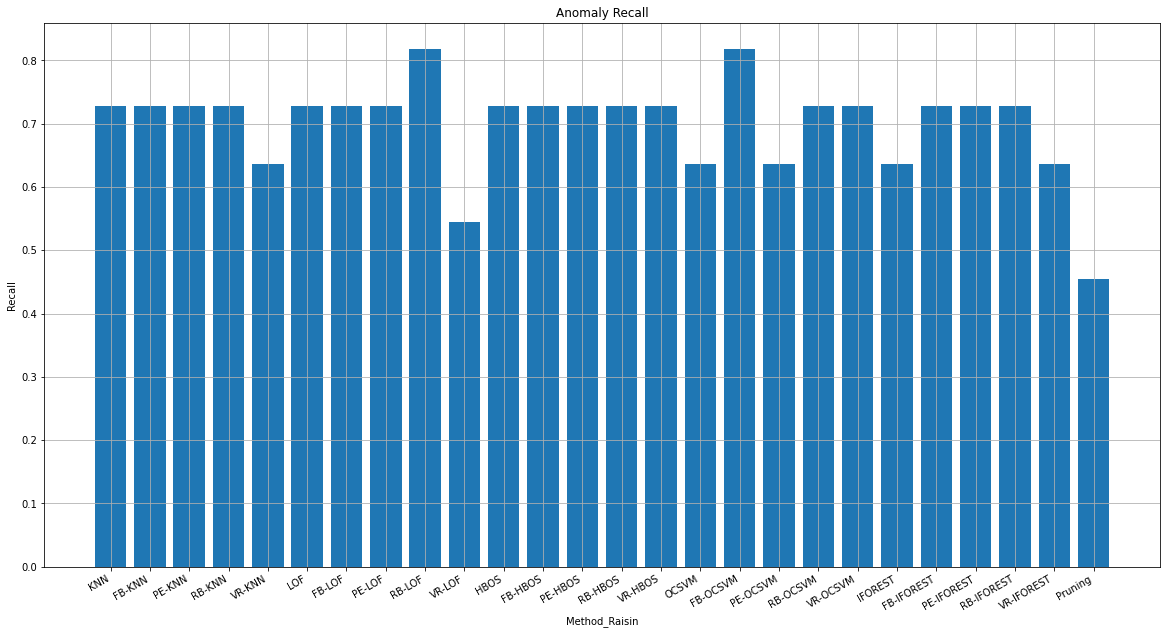

In [68]:
## recall ##
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


y = [recall_knn,recall_fb_knn,recall_pe_knn,recall_rb_knn,recall_vr_knn,
     recall_lof,recall_fb_lof,recall_pe_lof,recall_rb_lof,recall_vr_lof,
     recall_hbos,recall_fb_hbos,recall_pe_hbos,recall_rb_hbos,recall_vr_hbos,
     recall_ocsvm,recall_fb_ocsvm,recall_pe_ocsvm,recall_rb_ocsvm,recall_vr_ocsvm,
     recall_ifo,recall_fb_ifo,recall_pe_ifo,recall_rb_ifo,recall_vr_ifo, recall_pr]
x = ['KNN','FB-KNN','PE-KNN','RB-KNN','VR-KNN',
     'LOF','FB-LOF','PE-LOF','RB-LOF','VR-LOF',
     'HBOS','FB-HBOS','PE-HBOS','RB-HBOS','VR-HBOS',
     'OCSVM','FB-OCSVM','PE-OCSVM','RB-OCSVM','VR-OCSVM',
     'IFOREST','FB-IFOREST','PE-IFOREST','RB-IFOREST','VR-IFOREST','Pruning']
ax= plt.subplot()
fig = plt.bar(x,y)
#plt.xticks(x,y)
plt.title("Anomaly Recall")
plt.xlabel("Method_Raisin")
plt.ylabel("Recall")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.grid()
plt.show()




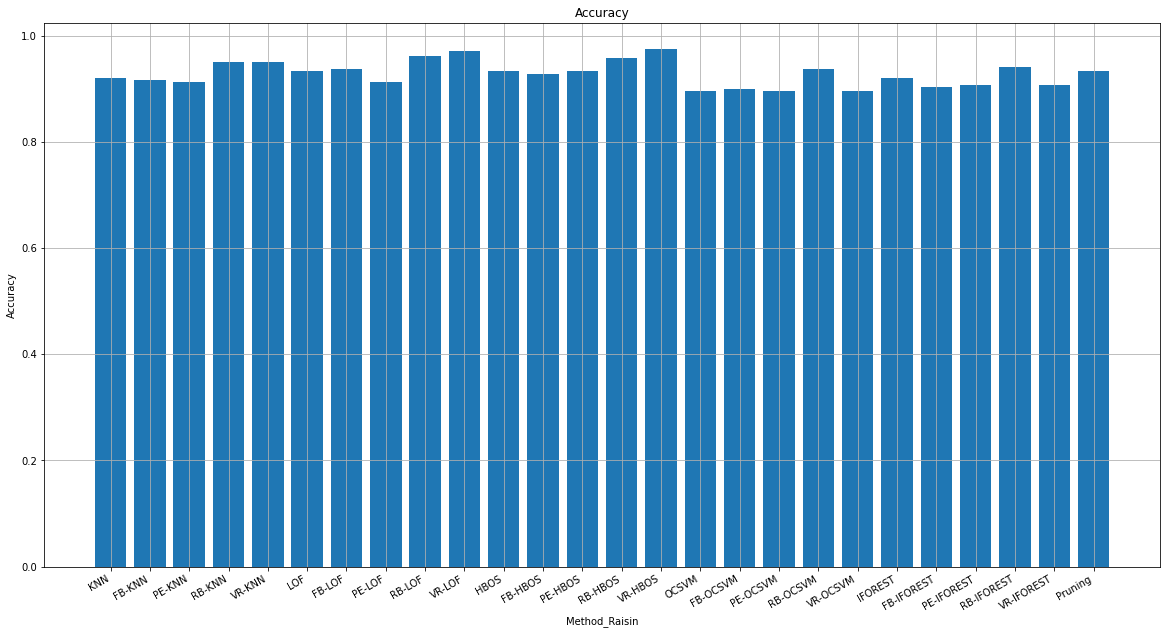

In [70]:
## Accuracy ##
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


y = [accuracy_knn,accuracy_fb_knn,accuracy_pe_knn,accuracy_rb_knn,accuracy_vr_knn,
     accuracy_lof,accuracy_fb_lof,accuracy_pe_lof,accuracy_rb_lof,accuracy_vr_lof,
     accuracy_hbos,accuracy_fb_hbos,accuracy_pe_hbos,accuracy_rb_hbos,accuracy_vr_hbos,
     accuracy_ocsvm,accuracy_fb_ocsvm,accuracy_pe_ocsvm,accuracy_rb_ocsvm,accuracy_vr_ocsvm,
     accuracy_ifo,accuracy_fb_ifo,accuracy_pe_ifo,accuracy_rb_ifo,accuracy_vr_ifo, accuracy_pr]
x = ['KNN','FB-KNN','PE-KNN','RB-KNN','VR-KNN',
     'LOF','FB-LOF','PE-LOF','RB-LOF','VR-LOF',
     'HBOS','FB-HBOS','PE-HBOS','RB-HBOS','VR-HBOS',
     'OCSVM','FB-OCSVM','PE-OCSVM','RB-OCSVM','VR-OCSVM',
     'IFOREST','FB-IFOREST','PE-IFOREST','RB-IFOREST','VR-IFOREST','Pruning']

ax= plt.subplot()
fig = plt.bar(x,y)
#plt.xticks(x,y)
plt.title("Accuracy")
plt.xlabel("Method_Raisin")
plt.ylabel("Accuracy")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.grid()
plt.show()

In [71]:
model_performance = pd.DataFrame(columns=['Accuracy','Recall','AUC','F1-Score','total time'])

model_performance.loc['KNN'] = [accuracy_knn, recall_knn, auc_knn, f1_knn,time_test_knn+time_train_knn]
model_performance.loc['FB-KNN_MEAN'] = [accuracy_fb_knn, recall_fb_knn, auc_fb_knn, f1_fb_knn,time_test_fb_knn+time_train_fb_knn]
model_performance.loc['FB-KNN_MAX'] = [accuracy_fb1_knn, recall_fb1_knn, auc_fb1_knn, f1_fb1_knn,time_test_fb1_max_knn+time_train_fb1_max_knn]
model_performance.loc['PE-KNN_MEAN'] = [accuracy_pe_knn, recall_pe_knn, auc_pe_knn, f1_pe_knn,time_test_pe_knn+time_train_pe_knn]
model_performance.loc['PE-KNN_MAX'] = [accuracy_pe1_knn, recall_pe1_knn, auc_pe1_knn, f1_pe1_knn,time_test_pe1_max_knn+time_train_pe1_max_knn]
model_performance.loc['PE-KNN_MEDIAN'] = [accuracy_pe2_knn, recall_pe2_knn, auc_pe2_knn, f1_pe2_knn,time_test_pe2_median_knn+time_train_pe2_median_knn]
model_performance.loc['RB-KNN_MEAN'] = [accuracy_rb_knn, recall_rb_knn, auc_rb_knn, f1_rb_knn,time_test_rb_knn+time_train_rb_knn]
model_performance.loc['RB-KNN_MAX'] = [accuracy_rb1_knn, recall_rb1_knn, auc_rb1_knn, f1_rb1_knn,time_test_rb1_max_knn+time_train_rb1_max_knn]
model_performance.loc['RB-KNN_MEDIAN'] = [accuracy_rb2_knn, recall_rb2_knn, auc_rb2_knn, f1_rb2_knn,time_test_rb2_median_knn+time_train_rb2_median_knn]
model_performance.loc['VR-KNN_MEAN'] = [accuracy_vr_knn, recall_vr_knn, auc_vr_knn, f1_vr_knn,time_test_vr_knn+time_train_vr_knn]
model_performance.loc['VR-KNN_MAX'] = [accuracy_vr1_knn, recall_vr1_knn, auc_vr1_knn, f1_vr1_knn,time_test_vr1_max_knn+time_train_vr1_max_knn]

model_performance.loc['LOF'] = [accuracy_lof, recall_lof, auc_lof, f1_lof,time_test_lof+time_train_lof]
model_performance.loc['FB-LOF_MEAN'] = [accuracy_fb_lof, recall_fb_lof, auc_fb_lof, f1_fb_lof,time_test_fb_lof+time_train_fb_lof]
model_performance.loc['FB-LOF_MAX'] = [accuracy_fb1_lof, recall_fb1_lof, auc_fb1_lof, f1_fb1_lof,time_test_fb1_max_lof+time_train_fb1_max_lof]
model_performance.loc['PE-LOF_MEAN'] = [accuracy_pe_lof, recall_pe_lof, auc_pe_lof, f1_pe_lof,time_test_pe_lof+time_train_pe_lof]
model_performance.loc['PE-LOF_MAX'] = [accuracy_pe1_lof, recall_pe1_lof, auc_pe1_lof, f1_pe1_lof,time_test_pe1_max_lof+time_train_pe1_max_lof]
model_performance.loc['PE-LOF_MEDIAN'] = [accuracy_pe2_lof, recall_pe2_lof, auc_pe2_lof, f1_pe2_lof,time_test_pe2_median_lof+time_train_pe2_median_lof]
model_performance.loc['RB-LOF_MEAN'] = [accuracy_rb_lof, recall_rb_lof, auc_rb_lof, f1_rb_lof,time_test_rb_lof+time_train_rb_lof]
model_performance.loc['RB-LOF_MAX'] = [accuracy_rb1_lof, recall_rb1_lof, auc_rb1_lof, f1_rb1_lof,time_test_rb1_max_lof+time_train_rb1_max_lof]
model_performance.loc['RB-LOF_MEDIAN'] = [accuracy_rb2_lof, recall_rb2_lof, auc_rb2_lof, f1_rb2_lof,time_test_rb2_median_lof+time_train_rb2_median_lof]
model_performance.loc['VR-LOF_MEAN'] = [accuracy_vr_lof, recall_vr_lof, auc_vr_lof, f1_vr_lof,time_test_vr_lof+time_train_vr_lof]
model_performance.loc['VR-LOF_MAX'] = [accuracy_vr1_lof, recall_vr1_lof, auc_vr1_lof, f1_vr1_lof,time_test_vr1_max_lof+time_train_vr1_max_lof]

model_performance.loc['HBOS'] = [accuracy_hbos, recall_hbos, auc_hbos, f1_hbos,time_test_hbos+time_train_hbos]
model_performance.loc['FB-HBOS_MEAN'] = [accuracy_fb_hbos, recall_fb_hbos, auc_fb_hbos, f1_fb_hbos,time_test_fb_hbos+time_train_fb_hbos]
model_performance.loc['FB-HBOS_MAX'] = [accuracy_fb1_hbos, recall_fb1_hbos, auc_fb1_hbos, f1_fb1_hbos,time_test_fb1_max_hbos+time_train_fb1_max_hbos]
model_performance.loc['PE-HBOS_MEAN'] = [accuracy_pe_hbos, recall_pe_hbos, auc_pe_hbos, f1_pe_hbos,time_test_pe_hbos+time_train_pe_hbos]
model_performance.loc['PE-HBOS_MAX'] = [accuracy_pe1_hbos, recall_pe1_hbos, auc_pe1_hbos, f1_pe1_hbos,time_test_pe1_max_hbos+time_train_pe1_max_hbos]
model_performance.loc['PE-HBOS_MEDIAN'] = [accuracy_pe2_hbos, recall_pe2_hbos, auc_pe2_hbos, f1_pe2_hbos,time_test_pe2_median_hbos+time_train_pe2_median_hbos]
model_performance.loc['RB-HBOS_MEAN'] = [accuracy_rb_hbos, recall_rb_hbos, auc_rb_hbos, f1_rb_hbos,time_test_rb_hbos+time_train_rb_hbos]
model_performance.loc['RB-HBOS_MAX'] = [accuracy_rb1_hbos, recall_rb1_hbos, auc_rb1_hbos, f1_rb1_hbos,time_test_rb1_max_hbos+time_train_rb1_max_hbos]
model_performance.loc['RB-HBOS_MEDIAN'] = [accuracy_rb2_hbos, recall_rb2_hbos, auc_rb2_hbos, f1_rb2_hbos,time_test_rb2_median_hbos+time_train_rb2_median_hbos]
model_performance.loc['VR-HBOS_MEAN'] = [accuracy_vr_hbos, recall_vr_hbos, auc_vr_hbos, f1_vr_hbos,time_test_vr_hbos+time_train_vr_hbos]
model_performance.loc['VR-HBOS_MAX'] = [accuracy_vr1_hbos, recall_vr1_hbos, auc_vr1_hbos, f1_vr1_hbos,time_test_vr1_max_hbos+time_train_vr1_max_hbos]

model_performance.loc['OCSVM'] = [accuracy_ocsvm, recall_ocsvm, auc_ocsvm, f1_ocsvm,time_test_ocsvm+time_train_ocsvm]
model_performance.loc['FB-OCSVM_MEAN'] = [accuracy_fb_ocsvm, recall_fb_ocsvm, auc_fb_ocsvm, f1_fb_ocsvm,time_test_fb_ocsvm+time_train_fb_ocsvm]
model_performance.loc['FB-OCSVM_MAX'] = [accuracy_fb1_ocsvm, recall_fb1_ocsvm, auc_fb1_ocsvm, f1_fb1_ocsvm,time_test_fb1_max_ocsvm+time_train_fb1_max_ocsvm]
model_performance.loc['PE-OCSVM_MEAN'] = [accuracy_pe_ocsvm, recall_pe_ocsvm, auc_pe_ocsvm, f1_pe_ocsvm,time_test_pe_ocsvm+time_train_pe_ocsvm]
model_performance.loc['PE-OCSVM_MAX'] = [accuracy_pe1_ocsvm, recall_pe1_ocsvm, auc_pe1_ocsvm, f1_pe1_ocsvm,time_test_pe1_max_ocsvm+time_train_pe1_max_ocsvm]
model_performance.loc['PE-OCSVM_MEDIAN'] = [accuracy_pe2_ocsvm, recall_pe2_ocsvm, auc_pe2_ocsvm, f1_pe2_ocsvm,time_test_pe2_median_ocsvm+time_train_pe2_median_ocsvm]
model_performance.loc['RB-OCSVM_MEAN'] = [accuracy_rb_ocsvm, recall_rb_ocsvm, auc_rb_ocsvm, f1_rb_ocsvm,time_test_rb_ocsvm+time_train_rb_ocsvm]
model_performance.loc['RB-OCSVM_MAX'] = [accuracy_rb1_ocsvm, recall_rb1_ocsvm, auc_rb1_ocsvm, f1_rb1_ocsvm,time_test_rb1_max_ocsvm+time_train_rb1_max_ocsvm]
model_performance.loc['RB-OCSVM_MEDIAN'] = [accuracy_rb2_ocsvm, recall_rb2_ocsvm, auc_rb2_ocsvm, f1_rb2_ocsvm,time_test_rb2_median_ocsvm+time_train_rb2_median_ocsvm]
model_performance.loc['VR-OCSVM_MEAN'] = [accuracy_vr_ocsvm, recall_vr_ocsvm, auc_vr_ocsvm, f1_vr_ocsvm,time_test_vr_ocsvm+time_train_vr_ocsvm]
model_performance.loc['VR-OCSVM_MAX'] = [accuracy_vr1_ocsvm, recall_vr1_ocsvm, auc_vr1_ocsvm, f1_vr1_ocsvm,time_test_vr1_max_ocsvm+time_train_vr1_max_ocsvm]

model_performance.loc['IFOREST'] = [accuracy_ifo, recall_ifo, auc_ifo, f1_ifo,time_test_ifo+time_train_ifo]
model_performance.loc['FB-IFOREST_MEAN'] = [accuracy_fb_ifo, recall_fb_ifo, auc_fb_ifo, f1_fb_ifo,time_test_fb_ifo+time_train_fb_ifo]
model_performance.loc['FB-IFOREST_MAX'] = [accuracy_fb1_ifo, recall_fb1_ifo, auc_fb1_ifo, f1_fb1_ifo,time_test_fb1_max_ifo+time_train_fb1_max_ifo]
model_performance.loc['PE-IFOREST_MEAN'] = [accuracy_pe_ifo, recall_pe_ifo, auc_pe_ifo, f1_pe_ifo,time_test_pe_ifo+time_train_pe_ifo]
model_performance.loc['PE-IFOREST_MAX'] = [accuracy_pe1_ifo, recall_pe1_ifo, auc_pe1_ifo, f1_pe1_ifo,time_test_pe1_max_ifo+time_train_pe1_max_ifo]
model_performance.loc['PE-IFOREST_MEDIAN'] = [accuracy_pe2_ifo, recall_pe2_ifo, auc_pe2_ifo, f1_pe2_ifo,time_test_pe2_median_ifo+time_train_pe2_median_ifo]
model_performance.loc['RB-IFOREST_MEAN'] = [accuracy_rb_ifo, recall_rb_ifo, auc_rb_ifo, f1_rb_ifo,time_test_rb_ifo+time_train_rb_ifo]
model_performance.loc['RB-IFOREST_MAX'] = [accuracy_rb1_ifo, recall_rb1_ifo, auc_rb1_ifo, f1_rb1_ifo,time_test_rb1_max_ifo+time_train_rb1_max_ifo]
model_performance.loc['RB-IFOREST_MEDIAN'] = [accuracy_rb2_ifo, recall_rb2_ifo, auc_rb2_ifo, f1_rb2_ifo,time_test_rb2_median_ifo+time_train_rb2_median_ifo]
model_performance.loc['VR-IFOREST_MEAN'] = [accuracy_vr_ifo, recall_vr_ifo, auc_vr_ifo, f1_vr_ifo,time_test_vr_ifo+time_train_vr_ifo]
model_performance.loc['VR-IFOREST_MAX'] = [accuracy_vr1_ifo, recall_vr1_ifo, auc_vr1_ifo, f1_vr1_ifo,time_test_vr1_max_ifo+time_train_vr1_max_ifo]


model_performance.loc['Pruning'] = [accuracy_pr, recall_pr, auc_pr, f1_pr,time_test_pr+time_train_pr]



In [72]:
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'AUC': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'total time':'{:.1f}'
                                                                     })

,Accuracy,Recall,AUC,F1-Score,total time
KNN,92.02%,72.73%,82.84%,93.38%,0.0
FB-KNN_MEAN,91.60%,72.73%,82.62%,93.10%,0.3
FB-KNN_MAX,92.02%,72.73%,82.84%,93.38%,0.3
PE-KNN_MEAN,91.18%,72.73%,82.40%,92.81%,0.0
PE-KNN_MAX,91.18%,72.73%,82.40%,92.81%,0.0
PE-KNN_MEDIAN,90.76%,63.64%,77.85%,92.41%,0.0
RB-KNN_MEAN,94.96%,72.73%,84.38%,95.46%,0.0
RB-KNN_MAX,90.76%,54.55%,73.53%,92.26%,0.0
RB-KNN_MEDIAN,94.54%,81.82%,88.49%,95.28%,0.0
VR-KNN_MEAN,94.96%,63.64%,80.06%,95.32%,0.3
